In [2]:
import copy
import itertools

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [3]:
# Agent class


class Agent:
    # Initialize object
    def __init__(self, x, y, kind, preference, world):
        self.x = x
        self.y = y
        self.kind = kind
        self.preference = preference  # satisfaction benchmark
        self.world = world

    # Method to gather array of neighbors' coordinates
    def know_neighbors(self):
        self.neighbors = [self.world.coords[x % self.world.size, y % self.world.size] for x, y in itertools.product(range(self.x - 1, self.x + 2), range(self.y - 1, self.y + 2))]

    # Method to define if cell is empty
    def vacant(self):
        return self.kind == 0

    # Method to measure happiness level
    def happiness(self):
        neighbor_kinds = [n.kind for n in self.neighbors]
        numsame = neighbor_kinds.count(self.kind)
        numvacant = neighbor_kinds.count(0)
        if numvacant == 8:
            if self.vacant():
                return 1.0
            return 0.0
        return (numsame - 1) / (8 - numvacant)  # Subtract 1 from the count of similar neighbors to exclude the agent itself.

    # Method to check if agent is dissatisfied
    def dissatisfied(self):
        return self.happiness() < self.preference

    # Method to swap places with another cell
    def swap(self, partner):
        self.kind, partner.kind = partner.kind, self.kind

In [4]:
# World class (grid of squares to represent world)


class World:
    # Initialize object, a square world with edges connected to each other like a torus
    def __init__(self, size, kinds, probs, preference):
        self.size = size  # length of one edge
        self.preference = preference  # satisfaction benchmark for agents
        self.coords = self.populate_world(kinds, probs, preference)
        [a.know_neighbors() for row in self.coords for a in row]
        self.num_dissatisfied = size**2
        self.num_vacant = sum([a.vacant() for row in self.coords for a in row])

    # Method to fill the world object grid with randomly placed vacant, red and blue cells
    def populate_world(self, kinds, probs, preference):
        return np.array(
            [
                [
                    Agent(x, y, np.random.choice(kinds, p=probs), preference, self)
                    for y in range(self.size)
                ]
                for x in range(self.size)
            ]
        )

    # Method to form array corresponding to the world object
    def atlas(self):
        return np.array([[a.kind for a in row] for row in self.coords])

    # Method to move unhappy agents to vacant plots
    def advance_turn(self):
        dissatisfied = []
        vacant = []
        for row in self.coords:
            for a in row:
                if a.vacant():
                    vacant.append(a)
                elif a.dissatisfied():
                    dissatisfied.append(a)
        self.num_dissatisfied = len(dissatisfied)
        np.random.shuffle(dissatisfied)
        np.random.shuffle(vacant)
        num_swap = min(self.num_dissatisfied, self.num_vacant)
        for indx in range(num_swap):
            dissatisfied[indx].swap(vacant[indx])

    # Method to measure happiness for each of the cell in the world grid and form array
    def happiness_distribution(self):
        return [a.happiness() for row in self.coords for a in row if not a.vacant()]

In [5]:
# WorldArchiving class to preserve/archive the deep copy images of the world at each turn


class WorldArchiving(World):
    # Initialize objects
    def __init__(self, size, kinds, probs, preference):
        super(WorldArchiving, self).__init__(size, kinds, probs, preference)
        self.archived_atlases = []
        self.mean_happiness = [np.mean(self.happiness_distribution())]

    # Method that saves the deep copy image in archived_atlases array
    def archive(self):
        self.archived_atlases.append(copy.deepcopy(self.atlas()))

    # Method that moves unhappy agents, then saves the deep copy image of world grid
    # and mean happiness for each iteration until percent of unhappy agents is below threshold
    def play(self, threshold=0.01):
        self.archive()
        while self.num_dissatisfied / (self.size**2) > threshold:
            self.advance_turn()
            self.archive()
            self.mean_happiness.append(np.mean(self.happiness_distribution()))

In [6]:
# Function that plots world atlas along with mean happiness for iteration level (turn)


def plot_atlas_happiness(worlds, turn):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    plt.style.use("ggplot")

    # Plot world atlas on left-hand-side
    cmap = ListedColormap(["white", "red", "blue"])
    ax[0].grid(False)
    ax[0].pcolor(worlds.archived_atlases[turn], cmap=cmap)

    # Plot happiness percent on right-hand-side
    ax[1].plot(
        range(1, len(worlds.archived_atlases[:turn]) + 1), worlds.mean_happiness[:turn]
    )
    plt.xlim([0, len(worlds.archived_atlases)])
    plt.ylim([0, 1])
    plt.xlabel("Time")
    plt.ylabel("Percent satisfied")
    plt.tight_layout()

    return fig

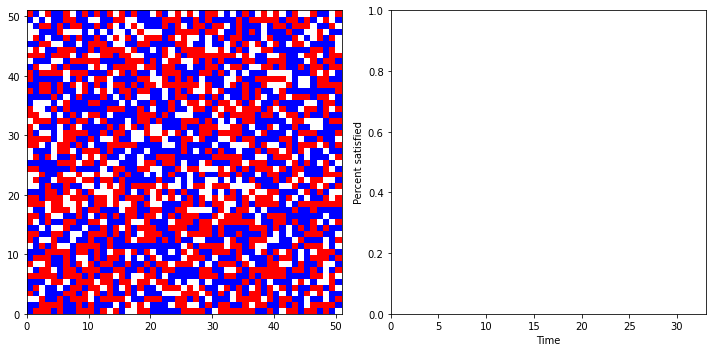

In [7]:
# Create 51x51 world grid with satisfaction benchmark 0.6 and
# randomly filled cells with:
#    0.2 portion of vacant cells,
#    0.4 portion of red cells and
#    0.4 portion of blue cells


np.random.seed(123)
worlds06 = WorldArchiving(51, [0, 1, 2], [0.2, 0.4, 0.4], 0.6)

# Apply play() method with zero threshold i.e until all agents are happy
worlds06.play(threshold=0.00)

# Plot world atlas and happiness level at the initial stage (turn=0)
plot_atlas_happiness(worlds06, turn=0)
plt.show()

In this piece of code above we have applied `worlds06.play(threshold=0.00)`. The processes involved in this operation can be summarized as follows: 

> a. Populate world with different kind of agents from Group 1 and Group 2 and vacant plots => <br>
> b. Take a snapshot image of the atlas => <br>
> b. Check each agent's neighbors => <br>
> b. Decide if each agent is dissatisfied with their neighborhood => <br>
> c. Repeat the process until all agents are checked => <br>
> d. Calculate the percentage of unhappy agents among all agents => <br>
> e. Move unhappy agents to a new location =>  <br>

These steps complete a round. Then, the code will continue with the next round until all agents have happiness level above *threshold=0.00*. The zero threshold in this case means that we leave no dissatisfied agents in the world grid. We can now plot the results of the final turn

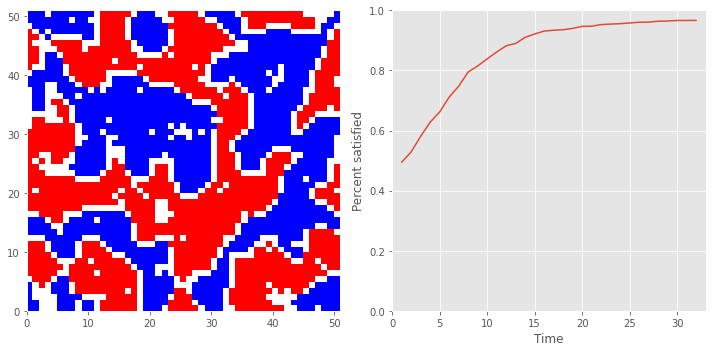

In [8]:
# Plot world atlas and happiness level at the final stage

plot_atlas_happiness(worlds06, len(worlds06.archived_atlases) - 1)
plt.show()